In [1]:
import numpy as np
from Code.Tutorial.algo_ssa import SSA
from Code.Tutorial.Dataset import load_scg
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pylab as plt

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

In [2]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, distance, duration, sampling_rate):
    data_tmp = data_tmp / np.max(data_tmp)

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal)

    t_peaks = t[peak_indices]
    peak_values = signal[peak_indices]
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=distance)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

In [4]:
def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / maxm

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    # mag_0 = get_mag_0(peaks2, data_tmp_raw)
    # mag_1 = get_mag_1(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1])

    return features

In [15]:

masks = []
areas = []
for N in range(7, 14):
    mask = np.ones((N, N))
    for i in range(N):
        for j in range(N):
            if i + j <= N//2 - 1 -1 - 1:
                mask[i, j] = 0
            if N % 2 == 0:
                if i + j >= 2 * N  - N // 2 :
                    mask[i, j] = 0
            else:
                if i + j >= 2 * N - 1  - N // 2:
                    mask[i, j] = 0
    # print(N, N//2 - 1, np.sum(mask) / N **2)

    # print(mask)
    masks.append(mask[:, ::-1])
    areas.append(np.sum(mask))

def optimized_separation(matrix):
    # N_range = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    N_range = [ 7, 8, 9, 10, 11, 12, 13]
    averages, covers = [], []
    for i in range(len(areas)):
        point = N_range[i]
        # print(i, point)
        average = np.sum(matrix[:point, :point] * masks[i]) / areas[i]
        cover = np.sum( ((matrix[:point, :point] * masks[i]) >= 0.08).astype(int) ) / areas[i]
        averages.append(average)
        covers.append(cover)
        # print(point, matrix[:point, :point].shape, average, cover)

    covers_diff = np.diff(covers)
    average_diff = np.diff(averages)

    # print(covers_diff)
    # print(np.sum((covers_diff > 0).astype(int)))

    # if np.sum((covers_diff > 0).astype(int))==0:
    #     flag = True
    pos = np.argmax(covers_diff)
    # if pos == 0:
    #     flag = True
    #     pos = np.argmax(covers_diff[1:]) + 1
    #
    # print(f'pos:{pos}')
    optimized_point = N_range[0] + 1 + pos
    # print(f'Before:{optimized_point}')
    # # if matrix[optimized_point, optimized_point - 1] > 0.7:
    # #     optimized_point += 1
    # if average_diff[pos] > 0:
    #     optimized_point = N_range[0]
    # print(f'After:{optimized_point}')
    return optimized_point


def features_indexes(signals, L, distance, show ):

    sampling_rate = fs
    idx = []
    features = []

    for i in range(len(signals)):
        signal = signals[i]
        if max(signal) > 1:
            continue

        ssa_ = SSA(signal, L)
        optimized_point = optimized_separation(ssa_.Wcorr)

        ssa_signal = ssa_.reconstruct(slice(optimized_point, L))
        peaks = get_peaks(ssa_signal, distance, duration, sampling_rate)

        if len(peaks) < 16:
            continue

        idx.append(i)

        if show:
            ssa_.plot_wcorr()
            # plt.savefig('./wcorr.jpg', dpi=300)

            plt.subplots(2, 1, figsize=(20, 8))
            plt.subplot(2, 1, 1)
            ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
            ssa_.reconstruct(slice(0, optimized_point)).plot(label='Noise Trend')
            plt.title('Noisy Signal and its Trend')
            plt.legend()
            plt.subplot(2, 1, 2)
            ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
            ssa_.reconstruct(slice(optimized_point, L)).plot(label='Reconstructed Signal')
            plt.title('Noisy Signal and Reconstructed Signal')
            plt.legend()
            # plt.savefig('./SSA_Effect.jpg', dpi=300)
            # plt.show()

        features.append(get_features(ssa_signal, peaks))
        break
    return features, idx


In [18]:
if __name__ == '__main__':
    signals_train, labels_train, duration, fs = load_scg(0.8, 'train')
    signals_test, labels_test, _, _ = load_scg(0.8, 'test')
    S_train, D_train = labels_train[:, -2], labels_train[:, -1]
    S_test, D_test = labels_test[:, -2], labels_test[:, -1]

    L = 100
    show = False

    features_train, idx_train = features_indexes(signals_train, L, 15, show)
    features_test, idx_test = features_indexes(signals_test, L, 10, show)

In [6]:
features_train_np = np.array(features_train)
features_test_np = np.array(features_test)
idx_train_np = np.array(idx_train)
idx_test_np = np.array(idx_test)

np.save('./features_train_0.8_5000_NoRR_auto', features_train_np)
np.save('./features_test_0.8_3000_NoRR_auto', features_test_np)
np.save('./idx_train_0.8_5000_NoRR_auto', idx_train_np)
np.save('./idx_test_0.8_3000_NoRR_auto', idx_test_np)

# features_train_np = np.load('./features_train_0.8_5000_NoRR_auto')
# features_test_np = np.load('./features_test_0.8_3000_NoRR_auto')
# idx_train = np.load('./idx_train_0.8_5000_NoRR_auto')
# idx_test = np.load('./idx_test_0.8_3000_NoRR_auto')


Saved plot to S_0.8.jpg


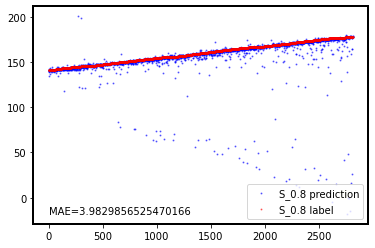

In [10]:
# from sklearn.linear_model import LinearRegression as LR
#
# reg = LR().fit(features_train_np[:, 3].reshape(-1, 1), S_train[idx_train])
# yhat = reg.predict(features_test_np[:, 3].reshape(-1, 1))
# np.mean(np.abs(yhat - S_test[idx_test]))
#
# from Tutorial.utils import plot_2vectors
# plot_2vectors( S_test[idx_test], yhat, True, 'S_0.8')

Saved plot to D_0.8.jpg


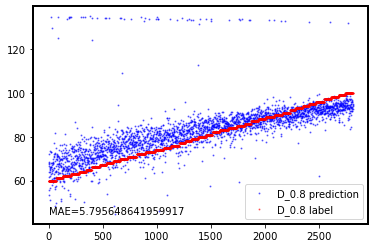

In [12]:
# reg = LR().fit(features_train_np[:, -1].reshape(-1, 1), D_train[idx_train])
# yhat = reg.predict(features_test_np[:, -1].reshape(-1, 1))
# np.mean(np.abs(yhat - D_test[idx_test]))
#
# from Tutorial.utils import plot_2vectors
# plot_2vectors( D_test[idx_test], yhat, True, 'D_0.8')